<a href="https://colab.research.google.com/github/YuehChun/2017-104Hackathon-AppWebService/blob/master/MitrPhol/MP_transformer_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Package

In [ ]:

import re,io,os,sys,time
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import Counter
import pandas as pd
import numpy as np

np.set_printoptions(threshold=sys.maxsize)

from torch.utils.data import DataLoader, DataLoader, TensorDataset
from tqdm.notebook import tqdm

print(torch.__version__)  # version = 1.12.1+cu113
print(np.__version__) # version = 1.21.6
print(pd.__version__) # version = 1.3.5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# V1 Version for preprocess

In [ ]:
v1_rowData = pd.read_csv("/content/drive/MyDrive/colabCSV/MP2_v2_1107.csv")

v1_rowData = v1_rowData.drop(["Unnamed: 0"], axis=1)

display(v1_rowData.describe(include="all"))
# add 
v1_rowData['V1_ValueY'] = v1_rowData['V1_ValueY'] * 100
StkRow = v1_rowData['STK']
tempDF = v1_rowData.drop(['STK' , 'ts'], axis = 1)
sc = MinMaxScaler(feature_range=(0, 1))
sc.fit(tempDF)
stk_list = pd.unique(v1_rowData['STK'])
display(v1_rowData.head(5))
columns_list = tempDF.columns

In [ ]:
timeWindows = 15
predictTimes = 5
batch_size = 64
X_Data = []
Y_Data = []
for stk in v1_rowData['STK'].unique():
    subDataSet = v1_rowData[v1_rowData['STK']==stk].drop([ 'STK' , 'ts'], axis = 1)
    np_data = sc.transform(subDataSet)
    np_dataY = subDataSet.to_numpy()
    for i in range(timeWindows, np_data.shape[0]-predictTimes):
        X_Data.append(np_data[i-timeWindows:i, :])
        # i = 15
        #  data[0:15,:] => append() => [1:15:10]
        Y_Data.append(np_dataY[i-1:i+predictTimes,:])
        #  data[20,:] => append() => [1:5:10] # data[20]

DataOfX, DataOfY = np.array(X_Data), np.array(Y_Data)

print(f"DataOfX.shape = {DataOfX.shape}")
print(f"DataOfY.shape = {DataOfY.shape}")
# display(DataOfY[0])

train_X, test_X, train_Y, test_Y = train_test_split(DataOfX,DataOfY, test_size=0.2, random_state=69)
print(f"train_X, test_X = {train_X.shape[0]}, {test_X.shape[0]}")
print(f"train_Y, test_Y = {train_Y.shape[0]}, {test_Y.shape[0]}")

# Transfer Data to train data

In [ ]:

train_data = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)


test_data = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).float())
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

dataiter = iter(train_loader)
data = dataiter.next()
features, labels = data
print(features.shape)
print(labels.shape)
print(features.dtype)
# print(features, labels)


# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
#@title [Func]Check performance
def check_performace(model,test_loader,columns_list):
    loss_total = []
    loss_features = {}
    s_loss_features = {}
    model.eval()
    for batch_idx, batch in enumerate(test_loader):
        inp_data = batch[0].to(torch.float).to(device)
        targets = batch[1].to(torch.float).to(device)
        target = targets.detach().numpy()
        targets = inp_data[:,-1,:].unsqueeze(1)
        with torch.no_grad():
            result = model(inp_data, targets)
        output = result.transpose(0,1).detach().numpy()
        for i in range(0,targets.shape[2]):
            if i in loss_features:
                loss_features[i].append(mean_squared_error(target[:,:,i], output[:,:,i]))
                s_loss_features[i].append(mean_squared_error(target[:,:2,i], output[:,:2,i]))
            else:
                loss_features[i] = [mean_squared_error(target[:,:,i], output[:,:,i])]
                s_loss_features[i] = [mean_squared_error(target[:,:2,i], output[:,:2,i])]
    for i,f in enumerate(loss_features):
        f_loss = loss_features[f]
        f_mse = sum(f_loss)/len(f_loss)
        s_f_loss = s_loss_features[f]
        s_f_mse = sum(s_f_loss)/len(s_f_loss)
        print(f"{columns_list[i]} MSE = {f_mse}, 2 records mse = {s_f_mse}")


# check_performace(model,test_loader)

In [ ]:
#@title [Func]CheckPoints 
def save_checkpoint(state, filename):
    path = f"/content/drive/MyDrive/Colab Notebooks/MP2/checkpoints/{filename}.pth.tar"
    print("=====> Saving checkpoint <=====")
    torch.save(state, path)


def load_checkpoint(filename, model, optimizer):
    print("=> Loading checkpoint")
    checkPointPath = f"/content/drive/MyDrive/Colab Notebooks/MP2/checkpoints/{filename}.pth.tar"
    if os.path.isfile(checkPointPath):
        checkpoint = torch.load(checkPointPath)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        return (checkpoint['step'],checkpoint['loss'])
    else:
        return (0,1e10)

In [ ]:
#@title [Func]Plot Pic

def plot_all_pic(plot_data):
#   plot_data = v1_rowData[v1_rowData['STK']==stk]

  X = plot_data.index
  color1 = "grey"
  color2 = "#87CEFA"
  color3 = "orange"
  PanLevelValueY = plot_data.PanLevelValueY

  plt.rcParams['font.size'] = 12
  plt.figure(figsize=(16, 16))


  SPBrixValueY = plot_data.SPBrixValueY
  predict_SPBrixValueY = plot_data.predict_SPBrixValueY
  ax1 = plt.subplot(421)
  plt.title("SPBrixValueY")
  ax1.set_xlabel('time (sminutes)')
  ax1.set_ylabel('SPBrixValueY', color=color1)
  ax1.plot(X, SPBrixValueY, color=color1, marker='2')
  ax1.plot(X, predict_SPBrixValueY, color=color3, marker='1')
  ax1.tick_params(axis='y', labelcolor=color1)
  ax1_2 = ax1.twinx()  
  ax1_2.set_ylabel('PanLevelValueY', color=color2)  
  ax1_2.plot(X, PanLevelValueY, color=color2)
  ax1_2.tick_params(axis='y', labelcolor=color2)
  ax1.grid()



  DensityValueY = plot_data.DensityValueY
  predict_DensityValueY = plot_data.predict_DensityValueY
  ax2 = plt.subplot(422)
  plt.title("DensityValueY")
  ax2.set_xlabel('time (minutes)')
  ax2.set_ylabel('DensityValueY', color=color1)
  ax2.plot(X, DensityValueY, color=color1, marker='2')
  ax2.plot(X, predict_DensityValueY, color=color3, marker='1')
  ax2.tick_params(axis='y', labelcolor=color1)

  ax2_2 = ax2.twinx()  
  ax2_2.set_ylabel('PanLevelValueY', color=color2)
  ax2_2.plot(X, PanLevelValueY, color=color2)
  ax2_2.tick_params(axis='y', labelcolor=color2)
  ax2.grid()


  HeatingSteamValueY = plot_data.HeatingSteamValueY
  predict_HeatingSteamValueY = plot_data.predict_HeatingSteamValueY
  ax3 = plt.subplot(423)
  plt.title("HeatingSteamValueY")
  ax3.set_xlabel('time (minutes)')
  ax3.set_ylabel('HeatingSteamValueY', color=color1)
  ax3.plot(X, HeatingSteamValueY, color=color1, marker='1')
  ax3.plot(X, predict_HeatingSteamValueY, color=color3, marker='2')
  ax3.tick_params(axis='y', labelcolor=color1)
  ax3_2 = ax3.twinx()  
  ax3_2.set_ylabel('PanLevelValueY', color=color2)  
  ax3_2.plot(X, PanLevelValueY, color=color2)
  ax3_2.tick_params(axis='y', labelcolor=color2)
  ax3.grid()



  TemperatureValueY = plot_data.TemperatureValueY
  predict_TemperatureValueY = plot_data.predict_TemperatureValueY
  ax4 = plt.subplot(424)
  plt.title("TemperatureValueY")
  ax4.set_xlabel('time (minutes)')
  ax4.set_ylabel('TemperatureValueY', color=color1)
  ax4.plot(X, TemperatureValueY, color=color1, marker='1')
  ax4.plot(X, predict_TemperatureValueY, color=color3, marker='2')
  ax4.tick_params(axis='y', labelcolor=color1)
  ax4_2 = ax4.twinx()  
  ax4_2.set_ylabel('PanLevelValueY', color=color2)  
  ax4_2.plot(X, PanLevelValueY, color=color2)
  ax4_2.tick_params(axis='y', labelcolor=color2)
  ax4.grid()

  



  WaterFlowValueY = plot_data.WaterFlowValueY
  predict_WaterFlowValueY = plot_data.predict_WaterFlowValueY
  ax5 = plt.subplot(425)
  plt.title("WaterFlowValueY")
  ax5.set_xlabel('time (minutes)')
  ax5.set_ylabel('WaterFlowValueY', color=color1)
  ax5.plot(X, WaterFlowValueY, color=color1, marker='1')
  ax5.plot(X, predict_WaterFlowValueY, color=color3, marker='2')
  ax5.tick_params(axis='y', labelcolor=color1)
  ax5_2 = ax5.twinx()  
  ax5_2.set_ylabel('PanLevelValueY', color=color2)  
  ax5_2.plot(X, PanLevelValueY, color=color2)
  ax5_2.tick_params(axis='y', labelcolor=color2)
  ax5.grid()



  MV_FEEDValueY = plot_data.MV_FEEDValueY
  predict_MV_FEEDValueY = plot_data.predict_MV_FEEDValueY
  ax6 = plt.subplot(426)
  plt.title("MV_FEEDValueY")
  ax6.set_xlabel('time (minutes)')
  ax6.set_ylabel('MV_FEEDValueY', color=color1)
  ax6.plot(X, MV_FEEDValueY, color=color1, marker='1')
  ax6.plot(X, predict_MV_FEEDValueY, color=color3, marker='2')
  ax6.tick_params(axis='y', labelcolor=color1)
  ax6_2 = ax6.twinx()  
  ax6_2.set_ylabel('PanLevelValueY', color=color2)  
  ax6_2.plot(X, PanLevelValueY, color=color2)
  ax6_2.tick_params(axis='y', labelcolor=color2)
  ax6.grid()


  VacuumValueY = plot_data.VacuumValueY
  predict_VacuumValueY = plot_data.predict_VacuumValueY
  ax7 = plt.subplot(427)
  plt.title("VacuumValueY")
  ax7.set_xlabel('time (minutes)')
  ax7.set_ylabel('VacuumValueY', color=color1)
  ax7.plot(X, VacuumValueY, color=color1, marker='1')
  ax7.plot(X, predict_VacuumValueY, color=color3, marker='2')
  ax7.tick_params(axis='y', labelcolor=color1)
  ax7_2 = ax7.twinx()  
  ax7_2.set_ylabel('PanLevelValueY', color=color2)  
  ax7_2.plot(X, PanLevelValueY, color=color2)
  ax7_2.tick_params(axis='y', labelcolor=color2)
  ax7.grid()


  StirrerCurrentValueY = plot_data.StirrerCurrentValueY
  predict_StirrerCurrentValueY = plot_data.predict_StirrerCurrentValueY
  ax8 = plt.subplot(428)
  plt.title("StirrerCurrentValueY")
  ax8.set_xlabel('time (minutes)')
  ax8.set_ylabel('StirrerCurrentValueY', color=color1)
  ax8.plot(X, StirrerCurrentValueY, color=color1, marker='1')
  ax8.plot(X, predict_StirrerCurrentValueY, color=color3, marker='2')
  ax8.tick_params(axis='y', labelcolor=color1)
  ax8_2 = ax8.twinx()  
  ax8_2.set_ylabel('PanLevelValueY', color=color2)  
  ax8_2.plot(X, PanLevelValueY, color=color2)
  ax8_2.tick_params(axis='y', labelcolor=color2)
  ax8.grid()



  plt.tight_layout()
  plt.show()


# Transformer

In [ ]:
#@title Transformer class

class Transformer(nn.Module):
    def __init__(
        self,
        feature_size,
        embedding_size,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        src_len,
        trg_len,
        p,
        device,
    ):
        super(Transformer, self).__init__()


        self.trg_len = trg_len
        self.src_len = src_len
        self.embedding_size = embedding_size
        self.feature_size = feature_size
        self.num_heads = num_heads

        self.fc_in_feature = nn.Linear(self.feature_size, self.embedding_size)
        self.fc_out_feature = nn.Linear(self.feature_size, self.embedding_size)
        self.src_position_embedding = nn.Embedding(self.src_len, self.embedding_size)
        self.trg_position_embedding = nn.Embedding(self.trg_len, self.embedding_size)
        

        self.device = device
        # 呼叫內建的 transformer
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            p,
        )
        self.fc_out = nn.Linear(self.embedding_size, self.feature_size)
        self.dropout = nn.Dropout(p)
        self.dropout_out = nn.Dropout(p)
        self.batch_first = True


    def forward(self, src, trg):
        # seq_length = 10 , N = batch size : 64
        
        src_seq_length  = self.src_len
        trg_seq_length  = self.trg_len
        N = src.size(0)
        feature_size = src.size(2)

        # src size = [64, 15, 10]
        # src size = [64, 5, 10]

        # src_positions.size() = torch.Size([7, 1])
        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .transpose(0,1)
            .to(self.device)
        )
        # print(src_positions) #[64 , 15]
        # print(f"src_positions size = {src_positions.size()}") # [15,64]

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .transpose(0,1)
            .to(self.device)
        )
        # print(f"trg_positions size = {trg_positions.size()}") # [5,64]
        # print("------")
        # print(f"src_position_embedding = {self.src_position_embedding}")
        # print(f"fc_in_feature(src) = {self.fc_in_feature(src)}")
        # print(self.src_positions)
        # print(f"self.fc_in_feature(src).size() = {self.fc_in_feature(src).size()}")
        # print(f"self.src_position_embedding(src_positions).size() = {self.src_position_embedding(src_positions).size()}")
         
        embed_src = self.dropout(
            (self.fc_in_feature(src) + self.src_position_embedding(src_positions))
        )

        #  + self.src_position_embedding(src_positions)
        embed_trg = self.dropout(
            (self.fc_out_feature(trg) + self.trg_position_embedding(trg_positions))
        )

        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )
        # print(f"embed_src = {embed_src.size()}")
        # print(f"embed_trg = {embed_trg.size()}")
        out = self.transformer(
            embed_src.transpose(0,1),
            embed_trg.transpose(0,1),
            # src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        
        out = self.fc_out(out)
        return out


In [ ]:
#@title Training hyperparameters


num_epochs = 4000
learning_rate = 3e-4

# Model hyperparameters
embedding_size = 64
feature_size = 10
num_heads = 8
num_encoder_layers = 8
num_decoder_layers = 6
src_len = 15
trg_len = 6
forward_expansion = 4
p = 0.1

In [ ]:
#@title setting of training

checkPointName = "Transformer_simu_i1_6x6_1"

# Tensorboard to get nice loss plot
# writer = SummaryWriter("runs/loss_plot")
step = 0

model = Transformer(
        feature_size,
        embedding_size,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        src_len,
        trg_len,
        p,
        device,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=50, verbose=True
)

criterion = nn.MSELoss()
step = 0


# Loading check point
step,loss_old = load_checkpoint(checkPointName, model, optimizer)
print(f"start step ={step}, loss = {loss_old}")

In [ ]:
#@title ==> Run Training
next_step = 0
for epoch in range(num_epochs):
    model.train()
    losses = []
    loop = tqdm(train_loader)
    for batch_idx, batch in enumerate(loop):
        # Get input and targets and get to cuda
        inp_data = batch[0].to(torch.float).to(device)
        target = batch[1].to(torch.float).to(device)
        # print(target.shape)
        # print(target.shape)
        # sys.exit()
        # print(f"inp_data size = {inp_data.size()}")
        # print(f"target size = {target.size()}")
        # Forward prop
        output = model(inp_data, target)
        # print(f"model of output size() = {output.size()}")
        output = output.transpose(0,1)
        # print(output.size())
        output = output[:,:-1,:] # remove last One
        target = target[:,1:,:] # remove first One

        optimizer.zero_grad()

        loss = criterion(output, target)
        losses.append(loss.item())

        # Back prop
        loss.backward()
        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()

        # plot to tensorboard
        # writer.add_scalar("Training loss", loss, global_step=step)


        mean_loss = sum(losses) / len(losses)
        loop.set_description(f"[Epoch {epoch}/{num_epochs}, mean_loss:{int(mean_loss)}]")
        loop.set_postfix(loss=loss.item())
    step += 1
    scheduler.step(mean_loss)


    if mean_loss<loss_old:
        print(f"step at {step} is loss = {mean_loss},")
        loss_old = mean_loss
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step,
            "loss": mean_loss,
        }
        save_checkpoint(checkpoint,checkPointName)
        if step >= next_step:
            next_step = step+20
            model.eval()
            check_performace(model,test_loader,columns_list)
            model.train()



  0%|          | 0/160 [00:00<?, ?it/s]

step at 1 is loss = 13464.019061279298,
=====> Saving checkpoint <=====
DensityValueY MSE = 6146.8123779296875, 2 records mse = 6117.378942871093
PanLevelValueY MSE = 6428.943347167969, 2 records mse = 6371.35673828125
HeatingSteamValueY MSE = 0.010468478058464825, 2 records mse = 0.010518898675218224
VacuumValueY MSE = 95938.47568359374, 2 records mse = 82740.00751953125
StirrerCurrentValueY MSE = 3991.0838256835937, 2 records mse = 4030.6278686523438
TemperatureValueY MSE = 4066.7416442871095, 2 records mse = 4065.6655456542967
WaterFlowValueY MSE = 2283.6048248291017, 2 records mse = 2284.118273925781
MV_FEEDValueY MSE = 1642.8258010864258, 2 records mse = 1654.751776123047
SPBrixValueY MSE = 6297.165502929687, 2 records mse = 6262.147705078125
V1_ValueY MSE = 1264.3067138671875, 2 records mse = 1265.7164398193358


  0%|          | 0/160 [00:00<?, ?it/s]

step at 2 is loss = 12826.795956420898,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 3 is loss = 12234.388076782227,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 4 is loss = 11603.942413330078,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 5 is loss = 10876.566751098633,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 6 is loss = 10208.156356811523,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 7 is loss = 9539.361080932616,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 8 is loss = 9007.018061828614,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 9 is loss = 8376.414974975585,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 10 is loss = 7819.528015136719,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 11 is loss = 7333.138311767578,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 12 is loss = 6982.886866760254,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 13 is loss = 6522.307805633545,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 14 is loss = 6187.703205871582,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 15 is loss = 5863.478088378906,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 16 is loss = 5582.175332641602,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 17 is loss = 5335.184977722168,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 18 is loss = 5037.533560562134,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 19 is loss = 4794.798004150391,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 20 is loss = 4552.773456859589,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 21 is loss = 4376.121509361267,
=====> Saving checkpoint <=====
DensityValueY MSE = 28.41616201400757, 2 records mse = 25.630395030975343
PanLevelValueY MSE = 282.3990245819092, 2 records mse = 223.26199684143066
HeatingSteamValueY MSE = 0.00971306583378464, 2 records mse = 0.00946988519281149
VacuumValueY MSE = 39632.90604248047, 2 records mse = 31601.124335479737
StirrerCurrentValueY MSE = 283.50817451477053, 2 records mse = 236.89532833099366
TemperatureValueY MSE = 23.5731153011322, 2 records mse = 28.051781320571898
WaterFlowValueY MSE = 1777.0971435546876, 2 records mse = 1607.7588912963868
MV_FEEDValueY MSE = 1210.4032470703125, 2 records mse = 1057.9189239501952
SPBrixValueY MSE = 29.75471134185791, 2 records mse = 29.020451259613036
V1_ValueY MSE = 106.54839038848877, 2 records mse = 108.66284284591674


  0%|          | 0/160 [00:00<?, ?it/s]

step at 22 is loss = 4243.561070919037,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 23 is loss = 4144.409601211548,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 24 is loss = 3989.0373606204985,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 25 is loss = 3878.1906803131105,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 26 is loss = 3753.217108535767,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 27 is loss = 3613.6280559062957,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 28 is loss = 3519.587631225586,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 29 is loss = 3379.8522975921633,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 30 is loss = 3264.6500014305116,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 31 is loss = 3200.6362339019774,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 32 is loss = 3020.294566965103,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 33 is loss = 2894.153451156616,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 34 is loss = 2782.797399139404,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 35 is loss = 2646.6986889362333,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 36 is loss = 2529.9263463497164,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 37 is loss = 2420.3565114974976,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 38 is loss = 2301.4058995246887,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 39 is loss = 2172.6370627880096,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 40 is loss = 2050.8377548217773,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 41 is loss = 1957.7154850006104,
=====> Saving checkpoint <=====
DensityValueY MSE = 66.57224569320678, 2 records mse = 22.305166387557982
PanLevelValueY MSE = 293.9159645080566, 2 records mse = 118.90021381378173
HeatingSteamValueY MSE = 0.013842290872707963, 2 records mse = 0.010347756091505289
VacuumValueY MSE = 28366.6712890625, 2 records mse = 22659.855212402344
StirrerCurrentValueY MSE = 225.13797750473023, 2 records mse = 197.63759388923646
TemperatureValueY MSE = 26.09806671142578, 2 records mse = 18.61320502758026
WaterFlowValueY MSE = 1776.2916442871094, 2 records mse = 1738.1693969726562
MV_FEEDValueY MSE = 1117.4885238647462, 2 records mse = 1110.1403396606445
SPBrixValueY MSE = 62.791984176635744, 2 records mse = 23.02969765663147
V1_ValueY MSE = 132.71605052948, 2 records mse = 154.95140342712403


  0%|          | 0/160 [00:00<?, ?it/s]

step at 42 is loss = 1822.9362577438355,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 43 is loss = 1702.2526696205139,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 44 is loss = 1620.8543574810028,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 45 is loss = 1511.7889072418213,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 46 is loss = 1427.3531560897827,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 47 is loss = 1333.6995376586915,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 48 is loss = 1242.6270756721497,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 49 is loss = 1161.9460010528564,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 50 is loss = 1081.2183347702025,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 51 is loss = 1019.4509450912476,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 52 is loss = 938.5368047714234,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 53 is loss = 861.078990650177,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 54 is loss = 802.7801684856415,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 55 is loss = 736.9966773033142,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 56 is loss = 681.2917834758758,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 57 is loss = 631.100482082367,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 58 is loss = 592.1463212013244,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 59 is loss = 545.0854263305664,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 60 is loss = 518.0984478950501,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 61 is loss = 481.57873005867003,
=====> Saving checkpoint <=====
DensityValueY MSE = 14.678373336791992, 2 records mse = 17.297775530815123
PanLevelValueY MSE = 188.84592666625977, 2 records mse = 113.50264854431153
HeatingSteamValueY MSE = 0.01013008162844926, 2 records mse = 0.007679679896682501
VacuumValueY MSE = 17237.726220703124, 2 records mse = 9438.267114257813
StirrerCurrentValueY MSE = 207.4664836406708, 2 records mse = 166.06719918251036
TemperatureValueY MSE = 10.042333281040191, 2 records mse = 6.746656221151352
WaterFlowValueY MSE = 1620.0103607177734, 2 records mse = 1722.6700775146485
MV_FEEDValueY MSE = 1076.7126327514648, 2 records mse = 1218.90662689209
SPBrixValueY MSE = 12.161611318588257, 2 records mse = 13.974871635437012
V1_ValueY MSE = 174.07846393585206, 2 records mse = 200.24023399353027


  0%|          | 0/160 [00:00<?, ?it/s]

step at 62 is loss = 442.75620074272155,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 63 is loss = 408.1448897361755,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 64 is loss = 392.61853179931643,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 65 is loss = 363.3093631744385,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 66 is loss = 346.35181646347047,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 67 is loss = 336.7555718421936,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 68 is loss = 312.6136236667633,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 69 is loss = 305.7464294910431,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 70 is loss = 278.3450762748718,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 72 is loss = 272.5953327655792,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 73 is loss = 263.8869076251984,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 74 is loss = 256.8300270080566,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 76 is loss = 246.0375301361084,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 77 is loss = 245.28212604522705,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 78 is loss = 240.45002479553222,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 79 is loss = 233.58108348846434,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 82 is loss = 233.50354952812194,
=====> Saving checkpoint <=====
DensityValueY MSE = 9.346089100837707, 2 records mse = 11.185338068008424
PanLevelValueY MSE = 216.17482528686523, 2 records mse = 205.72374572753907
HeatingSteamValueY MSE = 0.010079710348509251, 2 records mse = 0.0078905870905146
VacuumValueY MSE = 14993.692816162109, 2 records mse = 5027.842077636718
StirrerCurrentValueY MSE = 196.5193627357483, 2 records mse = 159.84148480892182
TemperatureValueY MSE = 15.73370099067688, 2 records mse = 6.902640908956528
WaterFlowValueY MSE = 1755.948194885254, 2 records mse = 1742.18310546875
MV_FEEDValueY MSE = 1104.16778717041, 2 records mse = 1117.6214645385742
SPBrixValueY MSE = 9.864889991283416, 2 records mse = 11.097883856296539
V1_ValueY MSE = 118.71483688354492, 2 records mse = 124.45459880828858


  0%|          | 0/160 [00:00<?, ?it/s]

step at 83 is loss = 228.06142358779908,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 84 is loss = 223.99156017303466,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 89 is loss = 218.81888527870177,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 91 is loss = 212.27943334579467,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 93 is loss = 211.4373249053955,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 102 is loss = 201.84627418518068,
=====> Saving checkpoint <=====
DensityValueY MSE = 6.566321182250976, 2 records mse = 7.663310396671295
PanLevelValueY MSE = 215.26839637756348, 2 records mse = 184.9627426147461
HeatingSteamValueY MSE = 0.011061882833018899, 2 records mse = 0.0075008620857261125
VacuumValueY MSE = 16216.612524414062, 2 records mse = 7214.7420104980465
StirrerCurrentValueY MSE = 228.83738079071045, 2 records mse = 195.23424005508423
TemperatureValueY MSE = 42.07588710784912, 2 records mse = 15.466239857673646
WaterFlowValueY MSE = 1762.667059326172, 2 records mse = 1774.049545288086
MV_FEEDValueY MSE = 1117.127212524414, 2 records mse = 1141.4877838134767
SPBrixValueY MSE = 7.606466853618622, 2 records mse = 7.50328728556633
V1_ValueY MSE = 138.15868740081788, 2 records mse = 141.41570892333985


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 105 is loss = 200.023939704895,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 111 is loss = 188.0164165019989,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 115 is loss = 186.0562083721161,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 125 is loss = 184.8006130695343,
=====> Saving checkpoint <=====
DensityValueY MSE = 7.750682997703552, 2 records mse = 7.6678446412086485
PanLevelValueY MSE = 199.60148105621337, 2 records mse = 149.82861862182617
HeatingSteamValueY MSE = 0.01441092207096517, 2 records mse = 0.009304433804936707
VacuumValueY MSE = 18799.395397949218, 2 records mse = 9593.076354980469
StirrerCurrentValueY MSE = 281.7922019958496, 2 records mse = 213.10607719421387
TemperatureValueY MSE = 41.354970932006836, 2 records mse = 20.124870133399963
WaterFlowValueY MSE = 1752.2006927490233, 2 records mse = 1789.679916381836
MV_FEEDValueY MSE = 1060.2905441284179, 2 records mse = 1181.3770233154296
SPBrixValueY MSE = 8.80043876171112, 2 records mse = 8.027536869049072
V1_ValueY MSE = 138.08581867218018, 2 records mse = 136.93142738342286


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 130 is loss = 183.1194676399231,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 131 is loss = 179.69621508121492,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 133 is loss = 177.70698070526123,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 137 is loss = 177.37034726142883,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 142 is loss = 176.8941102027893,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 144 is loss = 176.6704062461853,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 146 is loss = 174.0610876083374,
=====> Saving checkpoint <=====
DensityValueY MSE = 16.05810205936432, 2 records mse = 6.262516206502914
PanLevelValueY MSE = 302.14392013549804, 2 records mse = 317.2407928466797
HeatingSteamValueY MSE = 0.030150490486994384, 2 records mse = 0.014679835736751556
VacuumValueY MSE = 13763.456280517577, 2 records mse = 7171.989227294922
StirrerCurrentValueY MSE = 541.569857788086, 2 records mse = 363.8980628967285
TemperatureValueY MSE = 77.98130559921265, 2 records mse = 36.42300605773926
WaterFlowValueY MSE = 1984.5881591796874, 2 records mse = 1981.0517181396485
MV_FEEDValueY MSE = 1240.510612487793, 2 records mse = 1332.344888305664
SPBrixValueY MSE = 16.97176420688629, 2 records mse = 5.484749191999436
V1_ValueY MSE = 176.8525531768799, 2 records mse = 165.66737728118898


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 148 is loss = 172.3825922012329,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 151 is loss = 170.40282611846925,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 154 is loss = 170.38278484344482,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 157 is loss = 168.13244075775145,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 162 is loss = 168.02685952186584,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 163 is loss = 165.40388269424437,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 164 is loss = 164.8705258846283,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 165 is loss = 164.06001181602477,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 168 is loss = 160.66411380767823,
=====> Saving checkpoint <=====
DensityValueY MSE = 6.683137440681458, 2 records mse = 4.7405741751194
PanLevelValueY MSE = 246.53205184936525, 2 records mse = 257.46832885742185
HeatingSteamValueY MSE = 0.014211055333726108, 2 records mse = 0.010057585570029915
VacuumValueY MSE = 19164.795300292968, 2 records mse = 13109.78311767578
StirrerCurrentValueY MSE = 636.7539756774902, 2 records mse = 497.5402198791504
TemperatureValueY MSE = 79.7930076599121, 2 records mse = 48.34715566635132
WaterFlowValueY MSE = 2202.6127380371095, 2 records mse = 2108.889440917969
MV_FEEDValueY MSE = 1266.656120300293, 2 records mse = 1441.27978515625
SPBrixValueY MSE = 8.592557108402252, 2 records mse = 5.2926488548517225
V1_ValueY MSE = 123.09322547912598, 2 records mse = 114.80872497558593


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 179 is loss = 157.3636133670807,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 187 is loss = 156.85436682701112,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 201 is loss = 154.53994483947753,
=====> Saving checkpoint <=====
DensityValueY MSE = 17.105697298049925, 2 records mse = 12.460921025276184
PanLevelValueY MSE = 279.03848991394045, 2 records mse = 302.85825500488284
HeatingSteamValueY MSE = 0.015488357190042734, 2 records mse = 0.008278304850682617
VacuumValueY MSE = 12797.051025390625, 2 records mse = 5917.594790649414
StirrerCurrentValueY MSE = 495.40007934570315, 2 records mse = 415.2066284179688
TemperatureValueY MSE = 34.5967080116272, 2 records mse = 16.48758211135864
WaterFlowValueY MSE = 2227.953967285156, 2 records mse = 1981.2841796875
MV_FEEDValueY MSE = 1228.3173828125, 2 records mse = 1326.7366088867188
SPBrixValueY MSE = 18.427836632728578, 2 records mse = 12.234710431098938
V1_ValueY MSE = 238.45533409118653, 2 records mse = 238.7006649017334


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 208 is loss = 152.73715739250184,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 223 is loss = 150.52051582336426,
=====> Saving checkpoint <=====
DensityValueY MSE = 34.413159894943234, 2 records mse = 17.55975122451782
PanLevelValueY MSE = 295.84681396484376, 2 records mse = 276.9682476043701
HeatingSteamValueY MSE = 0.018089882447384298, 2 records mse = 0.011593646975234151
VacuumValueY MSE = 12693.178979492188, 2 records mse = 7180.980850219727
StirrerCurrentValueY MSE = 289.38192558288574, 2 records mse = 220.80176725387574
TemperatureValueY MSE = 30.18676915168762, 2 records mse = 16.391567325592042
WaterFlowValueY MSE = 2279.9026275634765, 2 records mse = 2071.5583557128907
MV_FEEDValueY MSE = 1270.022314453125, 2 records mse = 1309.758966064453
SPBrixValueY MSE = 35.82082071304321, 2 records mse = 18.623950552940368
V1_ValueY MSE = 264.0176464080811, 2 records mse = 239.41086807250977


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 226 is loss = 150.26574988365172,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 233 is loss = 146.09920964241027,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 248 is loss = 144.90486845970153,
=====> Saving checkpoint <=====
DensityValueY MSE = 42.8571277141571, 2 records mse = 8.765242207050324
PanLevelValueY MSE = 332.7486236572266, 2 records mse = 337.9235729217529
HeatingSteamValueY MSE = 0.01711065978743136, 2 records mse = 0.007338917173910886
VacuumValueY MSE = 13516.464239501953, 2 records mse = 6982.548620605468
StirrerCurrentValueY MSE = 300.7255485534668, 2 records mse = 203.76575155258178
TemperatureValueY MSE = 26.579717016220094, 2 records mse = 14.673062777519226
WaterFlowValueY MSE = 2278.993548583984, 2 records mse = 2047.3745422363281
MV_FEEDValueY MSE = 1238.7364990234375, 2 records mse = 1306.2293762207032
SPBrixValueY MSE = 45.78057489395142, 2 records mse = 10.713917970657349
V1_ValueY MSE = 260.92913208007815, 2 records mse = 225.26594200134278


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 260 is loss = 143.41253452301027,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 273 is loss = 143.22238059043883,
=====> Saving checkpoint <=====
DensityValueY MSE = 14.837598848342896, 2 records mse = 6.7140740036964415
PanLevelValueY MSE = 238.05187950134277, 2 records mse = 211.99831008911133
HeatingSteamValueY MSE = 0.014575867238454521, 2 records mse = 0.00812507887603715
VacuumValueY MSE = 13343.106198120116, 2 records mse = 6197.971240234375
StirrerCurrentValueY MSE = 201.29358348846435, 2 records mse = 154.42674016952515
TemperatureValueY MSE = 24.756634736061095, 2 records mse = 16.35043716430664
WaterFlowValueY MSE = 2176.961865234375, 2 records mse = 1866.7722534179688
MV_FEEDValueY MSE = 1186.7347457885742, 2 records mse = 1155.335319519043
SPBrixValueY MSE = 18.005942344665527, 2 records mse = 8.926632511615754
V1_ValueY MSE = 168.18834972381592, 2 records mse = 138.04362144470215


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 279 is loss = 142.076175737381,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 283 is loss = 141.22653682231902,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 294 is loss = 140.6408581018448,
=====> Saving checkpoint <=====
DensityValueY MSE = 24.159996128082277, 2 records mse = 10.067533862590789
PanLevelValueY MSE = 330.55992698669434, 2 records mse = 302.2707317352295
HeatingSteamValueY MSE = 0.01856458552647382, 2 records mse = 0.008360088197514414
VacuumValueY MSE = 13810.42788696289, 2 records mse = 6457.206060791015
StirrerCurrentValueY MSE = 396.2068408966064, 2 records mse = 206.15030002593994
TemperatureValueY MSE = 27.30647110939026, 2 records mse = 14.10256905555725
WaterFlowValueY MSE = 2175.439566040039, 2 records mse = 1852.0315551757812
MV_FEEDValueY MSE = 1170.0722793579102, 2 records mse = 1237.3234100341797
SPBrixValueY MSE = 24.952731084823608, 2 records mse = 10.842691993713379
V1_ValueY MSE = 216.63755264282227, 2 records mse = 177.29022598266602


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 297 is loss = 136.2602877140045,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 322 is loss = 132.74055716991424,
=====> Saving checkpoint <=====
DensityValueY MSE = 29.812878227233888, 2 records mse = 12.43015170097351
PanLevelValueY MSE = 319.09099235534666, 2 records mse = 323.71886138916017
HeatingSteamValueY MSE = 0.015434338035993278, 2 records mse = 0.008905858802609145
VacuumValueY MSE = 13875.142239379882, 2 records mse = 6139.740216064453
StirrerCurrentValueY MSE = 232.59084796905518, 2 records mse = 165.0398682117462
TemperatureValueY MSE = 17.87838578224182, 2 records mse = 11.884754943847657
WaterFlowValueY MSE = 2087.699642944336, 2 records mse = 1812.1069213867188
MV_FEEDValueY MSE = 1177.528611755371, 2 records mse = 1169.1385848999023
SPBrixValueY MSE = 32.49278454780578, 2 records mse = 13.425702118873597
V1_ValueY MSE = 176.40992889404296, 2 records mse = 135.1029821395874


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 340 is loss = 132.492840051651,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 361 is loss = 132.35227761268615,
=====> Saving checkpoint <=====
DensityValueY MSE = 31.12291829586029, 2 records mse = 10.428510475158692
PanLevelValueY MSE = 265.71621627807616, 2 records mse = 255.06622543334962
HeatingSteamValueY MSE = 0.019904072489589454, 2 records mse = 0.011020449921488762
VacuumValueY MSE = 12901.985119628906, 2 records mse = 6586.837927246093
StirrerCurrentValueY MSE = 207.4985071182251, 2 records mse = 172.75745673179625
TemperatureValueY MSE = 19.773834586143494, 2 records mse = 14.062317252159119
WaterFlowValueY MSE = 2007.5795593261719, 2 records mse = 1799.7108947753907
MV_FEEDValueY MSE = 1172.1467529296874, 2 records mse = 1164.410954284668
SPBrixValueY MSE = 32.87115919589996, 2 records mse = 11.963699620962142
V1_ValueY MSE = 166.0187843322754, 2 records mse = 138.47765502929687


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 363 is loss = 129.8593050479889,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 406 is loss = 129.48391919136049,
=====> Saving checkpoint <=====
DensityValueY MSE = 17.98355197906494, 2 records mse = 5.13798565864563
PanLevelValueY MSE = 296.0042900085449, 2 records mse = 254.5189151763916
HeatingSteamValueY MSE = 0.014040188933722674, 2 records mse = 0.008730752859264612
VacuumValueY MSE = 16301.595330810547, 2 records mse = 7677.789807128906
StirrerCurrentValueY MSE = 256.8783052444458, 2 records mse = 212.9779049873352
TemperatureValueY MSE = 24.75822958946228, 2 records mse = 23.46941521167755
WaterFlowValueY MSE = 2042.3688659667969, 2 records mse = 1924.2538055419923
MV_FEEDValueY MSE = 1206.3580230712892, 2 records mse = 1205.5128982543945
SPBrixValueY MSE = 18.662764453887938, 2 records mse = 5.9947381019592285
V1_ValueY MSE = 159.81740894317628, 2 records mse = 127.76408348083496


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 415 is loss = 125.57400534152984,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 416 is loss = 125.27618582248688,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 451 is loss = 125.23615994453431,
=====> Saving checkpoint <=====
DensityValueY MSE = 43.7952766418457, 2 records mse = 18.82847669124603
PanLevelValueY MSE = 446.987939453125, 2 records mse = 403.07090759277344
HeatingSteamValueY MSE = 0.019302495336160064, 2 records mse = 0.011116973962634802
VacuumValueY MSE = 11197.284106445313, 2 records mse = 5861.474645996093
StirrerCurrentValueY MSE = 217.39221334457397, 2 records mse = 166.32769072055817
TemperatureValueY MSE = 22.173069763183594, 2 records mse = 18.896955370903015
WaterFlowValueY MSE = 2016.1528564453124, 2 records mse = 1986.7602508544921
MV_FEEDValueY MSE = 1331.157943725586, 2 records mse = 1366.1487701416015
SPBrixValueY MSE = 40.31502285003662, 2 records mse = 17.438205575942995
V1_ValueY MSE = 156.28465194702147, 2 records mse = 133.42142162322997


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 454 is loss = 124.03296284675598,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 463 is loss = 123.56952381134033,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 477 is loss = 123.35121371746064,
=====> Saving checkpoint <=====
DensityValueY MSE = 39.23508977890015, 2 records mse = 14.21073421239853
PanLevelValueY MSE = 406.1983528137207, 2 records mse = 348.1411449432373
HeatingSteamValueY MSE = 0.019631528784520923, 2 records mse = 0.012710284418426454
VacuumValueY MSE = 12937.328912353516, 2 records mse = 6159.251547241211
StirrerCurrentValueY MSE = 280.4537654876709, 2 records mse = 238.94923133850097
TemperatureValueY MSE = 23.339235687255858, 2 records mse = 19.333595824241637
WaterFlowValueY MSE = 1974.4110321044923, 2 records mse = 1894.5850036621093
MV_FEEDValueY MSE = 1232.5474380493165, 2 records mse = 1237.550469970703
SPBrixValueY MSE = 37.45275559425354, 2 records mse = 13.896308839321136
V1_ValueY MSE = 193.5284683227539, 2 records mse = 152.80718383789062


  0%|          | 0/160 [00:00<?, ?it/s]

step at 478 is loss = 121.55709338188171,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 503 is loss = 120.86069536209106,
=====> Saving checkpoint <=====
DensityValueY MSE = 15.539254474639893, 2 records mse = 7.920535278320313
PanLevelValueY MSE = 409.6466552734375, 2 records mse = 379.2142364501953
HeatingSteamValueY MSE = 0.011913394904695451, 2 records mse = 0.00872272306587547
VacuumValueY MSE = 14374.496258544921, 2 records mse = 6446.754742431641
StirrerCurrentValueY MSE = 277.7095308303833, 2 records mse = 192.8110538005829
TemperatureValueY MSE = 18.09160304069519, 2 records mse = 13.948655247688293
WaterFlowValueY MSE = 1976.58349609375, 2 records mse = 1824.5425170898438
MV_FEEDValueY MSE = 1290.6377685546875, 2 records mse = 1224.7078842163087
SPBrixValueY MSE = 17.81474347114563, 2 records mse = 9.75808643102646
V1_ValueY MSE = 146.98536262512206, 2 records mse = 125.24948444366456


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 513 is loss = 119.95502736568451,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 532 is loss = 115.51579849720001,
=====> Saving checkpoint <=====
DensityValueY MSE = 32.6571569442749, 2 records mse = 19.753948783874513
PanLevelValueY MSE = 512.8842803955079, 2 records mse = 452.0817070007324
HeatingSteamValueY MSE = 0.018966483301483095, 2 records mse = 0.012865581503137945
VacuumValueY MSE = 13578.778759765624, 2 records mse = 7896.137051391602
StirrerCurrentValueY MSE = 348.2721435546875, 2 records mse = 247.74986028671265
TemperatureValueY MSE = 21.99207639694214, 2 records mse = 17.304678797721863
WaterFlowValueY MSE = 1853.6845428466797, 2 records mse = 1850.9215087890625
MV_FEEDValueY MSE = 1288.1508377075195, 2 records mse = 1232.458854675293
SPBrixValueY MSE = 34.96167302131653, 2 records mse = 22.292466402053833
V1_ValueY MSE = 168.6945941925049, 2 records mse = 149.1353343963623


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 555 is loss = 113.89231839179993,
=====> Saving checkpoint <=====
DensityValueY MSE = 24.569414138793945, 2 records mse = 12.72499259710312
PanLevelValueY MSE = 366.20643119812013, 2 records mse = 281.4423515319824
HeatingSteamValueY MSE = 0.010751849901862443, 2 records mse = 0.009687774733174592
VacuumValueY MSE = 14139.913043212891, 2 records mse = 6037.15729675293
StirrerCurrentValueY MSE = 318.2972749710083, 2 records mse = 207.3018939971924
TemperatureValueY MSE = 16.675054216384886, 2 records mse = 14.19394588470459
WaterFlowValueY MSE = 1739.5799133300782, 2 records mse = 1732.3219757080078
MV_FEEDValueY MSE = 1214.9835998535157, 2 records mse = 1183.7756225585938
SPBrixValueY MSE = 26.581553483009337, 2 records mse = 14.571478295326234
V1_ValueY MSE = 133.10775985717774, 2 records mse = 116.90406093597412


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 597 is loss = 111.76837885379791,
=====> Saving checkpoint <=====
DensityValueY MSE = 23.087936806678773, 2 records mse = 13.970423460006714
PanLevelValueY MSE = 407.1906513214111, 2 records mse = 341.9661361694336
HeatingSteamValueY MSE = 0.012516156188212335, 2 records mse = 0.00878350252751261
VacuumValueY MSE = 15095.905978393555, 2 records mse = 7317.010018920899
StirrerCurrentValueY MSE = 309.770201587677, 2 records mse = 218.76520056724547
TemperatureValueY MSE = 21.92060685157776, 2 records mse = 18.54496772289276
WaterFlowValueY MSE = 1799.3608489990233, 2 records mse = 1841.187060546875
MV_FEEDValueY MSE = 1259.4877182006835, 2 records mse = 1283.580810546875
SPBrixValueY MSE = 24.780413508415222, 2 records mse = 15.066140389442443
V1_ValueY MSE = 143.22634334564208, 2 records mse = 128.94870700836182


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 00648: reducing learning rate of group 0 to 3.0000e-05.


  0%|          | 0/160 [00:00<?, ?it/s]

step at 649 is loss = 110.76661639213562,
=====> Saving checkpoint <=====
DensityValueY MSE = 11.066734206676482, 2 records mse = 7.4238767385482785
PanLevelValueY MSE = 379.944864654541, 2 records mse = 340.32526473999025
HeatingSteamValueY MSE = 0.01123134563677013, 2 records mse = 0.00816038514021784
VacuumValueY MSE = 15422.450399780273, 2 records mse = 6383.011448669434
StirrerCurrentValueY MSE = 322.3130023956299, 2 records mse = 217.38205218315125
TemperatureValueY MSE = 18.464655470848083, 2 records mse = 16.303398776054383
WaterFlowValueY MSE = 1755.6072204589843, 2 records mse = 1777.4368682861327
MV_FEEDValueY MSE = 1171.6213607788086, 2 records mse = 1187.9528533935547
SPBrixValueY MSE = 13.68111573457718, 2 records mse = 9.639006960391999
V1_ValueY MSE = 116.46952781677246, 2 records mse = 100.37252388000488


  0%|          | 0/160 [00:00<?, ?it/s]

step at 650 is loss = 106.60261604785919,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 653 is loss = 103.53228878974915,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 657 is loss = 102.81179811954499,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 658 is loss = 102.42855260372161,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 660 is loss = 102.42058210372925,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

step at 661 is loss = 100.80430748462678,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 665 is loss = 100.7629717350006,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 683 is loss = 100.40223743915558,
=====> Saving checkpoint <=====
DensityValueY MSE = 15.80983783006668, 2 records mse = 9.930833733081817
PanLevelValueY MSE = 410.6558250427246, 2 records mse = 352.62911529541014
HeatingSteamValueY MSE = 0.012626850558444858, 2 records mse = 0.009077882987912744
VacuumValueY MSE = 15494.713133239746, 2 records mse = 6940.491204833985
StirrerCurrentValueY MSE = 336.960936164856, 2 records mse = 218.10766124725342
TemperatureValueY MSE = 19.549614667892456, 2 records mse = 16.53944835662842
WaterFlowValueY MSE = 1817.056234741211, 2 records mse = 1809.0257263183594
MV_FEEDValueY MSE = 1252.4984786987304, 2 records mse = 1238.7965286254882
SPBrixValueY MSE = 18.248105227947235, 2 records mse = 12.147578918933869
V1_ValueY MSE = 125.73136234283447, 2 records mse = 107.9348180770874


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 694 is loss = 99.03889453411102,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 705 is loss = 98.69838178157806,
=====> Saving checkpoint <=====
DensityValueY MSE = 13.812319552898407, 2 records mse = 9.022448122501373
PanLevelValueY MSE = 407.81542320251464, 2 records mse = 351.268327331543
HeatingSteamValueY MSE = 0.011301629361696541, 2 records mse = 0.00877557557541877
VacuumValueY MSE = 15737.497898864745, 2 records mse = 7240.261383056641
StirrerCurrentValueY MSE = 350.36383562088014, 2 records mse = 228.1207021713257
TemperatureValueY MSE = 19.449537372589113, 2 records mse = 17.007213091850282
WaterFlowValueY MSE = 1814.058984375, 2 records mse = 1831.789697265625
MV_FEEDValueY MSE = 1255.1395553588868, 2 records mse = 1257.926513671875
SPBrixValueY MSE = 16.186120057106017, 2 records mse = 10.99388945698738
V1_ValueY MSE = 126.58349266052247, 2 records mse = 108.22728452682495


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 714 is loss = 97.44385176897049,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 00765: reducing learning rate of group 0 to 3.0000e-06.


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 809 is loss = 97.18275475502014,
=====> Saving checkpoint <=====
DensityValueY MSE = 14.276971793174743, 2 records mse = 10.11468294262886
PanLevelValueY MSE = 408.70030174255373, 2 records mse = 342.70079307556153
HeatingSteamValueY MSE = 0.011711320909671485, 2 records mse = 0.008952361438423396
VacuumValueY MSE = 15824.928192138672, 2 records mse = 7635.178503417968
StirrerCurrentValueY MSE = 347.88571338653566, 2 records mse = 232.72077131271362
TemperatureValueY MSE = 22.39537920951843, 2 records mse = 18.21120171546936
WaterFlowValueY MSE = 1831.076119995117, 2 records mse = 1829.373779296875
MV_FEEDValueY MSE = 1262.3434127807618, 2 records mse = 1265.3396881103515
SPBrixValueY MSE = 17.060918283462524, 2 records mse = 12.469342267513275
V1_ValueY MSE = 128.20966987609864, 2 records mse = 108.33219890594482


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 828 is loss = 96.20940766334533,
=====> Saving checkpoint <=====


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 861 is loss = 95.9594850063324,
=====> Saving checkpoint <=====
DensityValueY MSE = 14.198720371723175, 2 records mse = 10.092950332164765
PanLevelValueY MSE = 410.1638603210449, 2 records mse = 344.65836296081545
HeatingSteamValueY MSE = 0.011696887225843966, 2 records mse = 0.00892873858101666
VacuumValueY MSE = 15776.199417114258, 2 records mse = 7580.165498352051
StirrerCurrentValueY MSE = 351.657977104187, 2 records mse = 237.39341421127318
TemperatureValueY MSE = 21.78600881099701, 2 records mse = 17.75673840045929
WaterFlowValueY MSE = 1822.8523010253907, 2 records mse = 1825.7096038818358
MV_FEEDValueY MSE = 1252.791844177246, 2 records mse = 1259.1440658569336
SPBrixValueY MSE = 17.08032069206238, 2 records mse = 12.547684276103974
V1_ValueY MSE = 127.96353874206542, 2 records mse = 108.36100387573242


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 00912: reducing learning rate of group 0 to 3.0000e-07.


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 00963: reducing learning rate of group 0 to 3.0000e-08.


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 977 is loss = 95.15194897651672,
=====> Saving checkpoint <=====
DensityValueY MSE = 13.992192697525024, 2 records mse = 9.589015913009643
PanLevelValueY MSE = 407.5909313201904, 2 records mse = 340.4689914703369
HeatingSteamValueY MSE = 0.011348517541773618, 2 records mse = 0.00871572874020785
VacuumValueY MSE = 15501.73076171875, 2 records mse = 7074.079417419433
StirrerCurrentValueY MSE = 344.8972053527832, 2 records mse = 224.81153497695922
TemperatureValueY MSE = 21.482326340675353, 2 records mse = 17.55776720046997
WaterFlowValueY MSE = 1830.0059967041016, 2 records mse = 1826.0859344482421
MV_FEEDValueY MSE = 1256.5389862060547, 2 records mse = 1260.491358947754
SPBrixValueY MSE = 16.766760516166688, 2 records mse = 11.874366807937623
V1_ValueY MSE = 128.40410404205323, 2 records mse = 108.82488040924072


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 01028: reducing learning rate of group 0 to 3.0000e-09.


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

step at 1600 is loss = 95.11994783878326,
=====> Saving checkpoint <=====
DensityValueY MSE = 13.94610413312912, 2 records mse = 9.561132407188415
PanLevelValueY MSE = 406.9762336730957, 2 records mse = 339.90289039611815
HeatingSteamValueY MSE = 0.011384657374583185, 2 records mse = 0.008723505807574838
VacuumValueY MSE = 15456.981500244141, 2 records mse = 7066.459985351563
StirrerCurrentValueY MSE = 344.04358329772947, 2 records mse = 224.2984006881714
TemperatureValueY MSE = 21.46295568943024, 2 records mse = 17.52764825820923
WaterFlowValueY MSE = 1826.6055053710938, 2 records mse = 1821.9277252197267
MV_FEEDValueY MSE = 1255.011962890625, 2 records mse = 1259.4109313964843
SPBrixValueY MSE = 16.718440616130827, 2 records mse = 11.845537042617797
V1_ValueY MSE = 128.1756311416626, 2 records mse = 108.55025157928466


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

# Check & Test

In [ ]:
#@title Plot Predict

import seaborn as sns
import matplotlib.pyplot as plt



timeWindows = 15
# predictTimes = 5
plot_X_Data = []
plot_Y_Data = []
plot_stk = 4803
# for stk in v1_rowData['STK'].unique():
subDataSet = v1_rowData[v1_rowData['STK']==plot_stk].drop([ 'STK' , 'ts'], axis = 1)
subDataSet = subDataSet.reset_index(drop=True)
np_data = sc.transform(subDataSet)
np_dataY = subDataSet.to_numpy()
for i in range(timeWindows, np_data.shape[0]):
    plot_X_Data.append(np_data[i-timeWindows:i, :])
    plot_Y_Data.append(np_dataY[i,:])

plot_DataOfX, plot_DataOfY = np.array(plot_X_Data), np.array(plot_Y_Data)


model.eval()
with torch.no_grad():
    x = torch.FloatTensor(plot_DataOfX)
    y = torch.FloatTensor(plot_DataOfY).unsqueeze(1)
    result = model(x,y)
    # predict = result.permute(1,2,0)
    predict = result.transpose(0,1)
    predict = predict[:,:-1,:] # remove last One

    print(f"predict.size() = {predict.size()}")

# print(f"result.size() = {result.size()}")
# print(f"predict is result permute(1,2,0) = {predict.size()}")
    # print(i)
# result
predict_value = pd.DataFrame(predict)
# print(subDataSet.shape) # 113,10
# print(plot_DataOfX.shape) # 93, 15, 10
# print(plot_DataOfY.shape) # 93, 10


predict.size() = torch.Size([98, 5, 10])


In [ ]:
pp = {} # predict for plot
for a in range(0,timeWindows):
    pp[a] = {}
    for col in columns_list:
        pp[a][col] = []


for i,records in enumerate(predict):
    time_index = timeWindows + i
    pp[time_index] = {}
    for fea,row in zip(columns_list,records):
        pp[time_index][fea] = torch.mean(row)

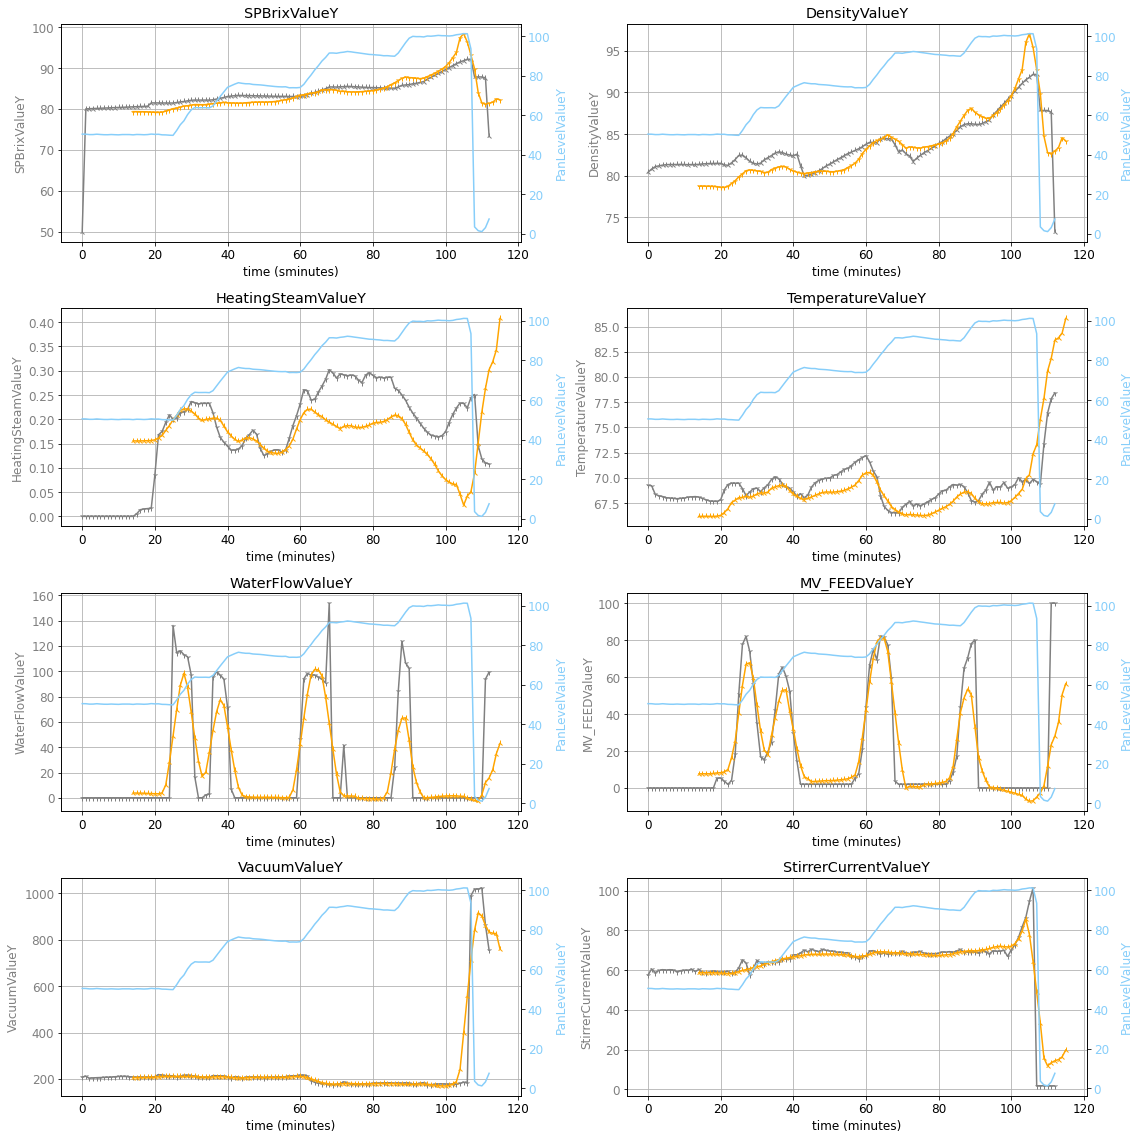

In [ ]:
pp = {} # predict for plot
for a in range(0,timeWindows):
    pp[a] = {}
    for col in columns_list:
        pp[a][col] = []

# nums: List[int]
for i,row in enumerate(predict): # timeWindows ~ (end - predict_len)
    # print(row) # 5,10
    for j,fea_zip in enumerate(row): # 0 ~ predict_len
        time_index = timeWindows + i + j -1
        if not time_index in pp:
            pp[time_index] = {}
            for col in columns_list:
                pp[time_index][col] = []
        for col,fea_zip in zip(columns_list,fea_zip):
            pp[time_index][col].append(fea_zip)

for i in range(0,len(pp)):
    for f in pp[i]:
        if len(pp[i][f]) == 0:
            f_mean = 0
            pp[i][f] = None
        else:
            f_mean = sum(pp[i][f]) / len(pp[i][f])
            pp[i][f] = float(f_mean)

df_pp = pd.DataFrame(pp)
predict_df = df_pp.T.add_prefix("predict_")
plot_all = pd.concat([subDataSet, predict_df], axis=1)
plot_all_pic(plot_all)
